### aim: Fig-spat-trend

### date: 

In [4]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [5]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [6]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 13}
plt.rcParams['text.usetex'] = True
plt.rc('font', **font)

## extraction code is below, but put in extract_2d_seas.py for batchsubmission purposes

In [7]:

ex = False

def make_yearlist(yrst, yrend, prod, \
                 baseDir = '/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/{prod}/{prod}_wind_daily_1x1_{yrs[i]}.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist


if ex:
    savenam = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/PlankTOMmask_regridrecalc.nc'
    cdomask = xr.open_dataset(savenam)
    tmask = cdomask.tmask

    sdir = '/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/intProc/'

    print('pojd')


    tn = ['MERRA','NCEP-DOE','NCEP-NCAR','ERA5','UKESM']
    tn = ['JRA']
    tn = ['UKESM-NOZONE']
    starts = [1980,1979,1948, 1940, 1940]

    for i in range(0,5):
        print(tn[i])
        en = 2020
        ds = xr.open_mfdataset(make_yearlist(starts[i], en, tn[i]))
        ncarst = starts[i]
        ds_DJF = ds.wspd10m.sel(time_counter=slice(f'{ncarst}-01-01', f'{en+1}-01-01')).\
        sel(time_counter=(ds['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()

        ds_MAM = ds.wspd10m.sel(time_counter=slice(f'{ncarst}-01-01', f'{en+1}-01-01')).\
        sel(time_counter=(ds['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean()

        ds_JJA = ds.wspd10m.sel(time_counter=slice(f'{ncarst}-01-01', f'{en+1}-01-01')).\
        sel(time_counter=(ds['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean()

        ds_SON = ds.wspd10m.sel(time_counter=slice(f'{ncarst}-01-01', f'{en+1}-01-01')).\
        sel(time_counter=(ds['time_counter.season'] == 'SON')).groupby('time_counter.year').mean()
        
        ds_FY = ds.wspd10m.sel(time_counter=slice(f'{ncarst}-01-01', f'{en+1}-01-01')).groupby('time_counter.year').mean()

        new_ds = xr.Dataset({
            'DJF': ds_DJF,
            'MAM': ds_MAM,
            'JJA': ds_JJA,
            'SON': ds_SON,
            'FY': ds_FY,

        })

        new_ds.to_netcdf(f'{sdir}/{tn[i]}_2d-seas-wspd-ts.nc')

In [8]:
import pymannkendall as mk
from scipy import stats

def give_trends(ts_y):

    ts_x = np.arange(0,len(ts_y))
    trend, h, mk_p, z, Tau, s, var_s, mk_slope, intercept = mk.original_test(ts_y)
    lin_slope, intercept, r_value, lin_p, std_err = stats.linregress(ts_x,ts_y)
    
    return mk_slope, mk_p, lin_slope, lin_p

### calculate 2d trends and significance

In [9]:
def get_trends(dsnam,seas,yst,yen):
    
    sdir = '/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/intProc/'
    
    tds = xr.open_dataset(f'{sdir}/{dsnam}_2d-seas-wspd-ts.nc')
    w = tds[seas].sel(year=slice(yst,yen)).sel(lat = slice(-90,-30)).values

    mk_slope_ar = np.zeros([60,360])
    mk_p_ar = np.zeros([60,360])
    lin_slope_ar = np.zeros([60,360])
    lin_p_ar = np.zeros([60,360])

    for y in range(0,60):
        if y%10 == 0:
            print(y)
        for x in range(0,360):
            
            ts = w[:,y,x]
            mk_s, mk_p, lin_s, lin_p = give_trends(ts)
            mk_slope_ar[y,x] = mk_s
            mk_p_ar[y,x] = mk_p            
            lin_slope_ar[y,x] = lin_s
            lin_p_ar[y,x] = lin_p     
        
    savenam = f'/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/intProc/TRENDS-{dsnam}-{seas}-{yst}-{yen}.nc'
    print(savenam)
    data_vars = {'mk_slope':(['lat', 'lon'], mk_slope_ar),
        'mk_p':(['lat', 'lon'], mk_p_ar),
        'lin_slope':(['lat', 'lon'], lin_slope_ar),
        'lin_p':(['lat', 'lon'], lin_p_ar),
    }
# # define coordinates
    coords = {'lat': (['lat'],tds.lat[0:60]),
            'lon': (['lon'],tds.lon)}

    
    # define global attributes
    attrs = {'made in':'windEval/plottingCode/Fig-spatialtrends.ipynb',
    }
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)

    ds.to_netcdf(savenam)
    return ds



## get spatial trends

In [18]:
ex = False
if ex:


    tn = ['MERRA','NCEP-NCAR','NCEP-DOE','ERA5','UKESM','UKESM-NOZONE']
    tn = ['JRA']
    tn = ['MERRA','NCEP-NCAR','ERA5','UKESM']
    tn = ['UKESM_NOZONE']
    tn = ['UKESMEM']
    tseas = ['FY','DJF','JJA',]

    for n in tn:
        for s in tseas:
            print(f'{n}, {s}')
            ds = get_trends(n,s,1980,2019)
            ds = get_trends(n,s,1980,1999)

## code to make map of spatial trends

In [27]:

plt.rcParams['hatch.color'] = 'k'
plt.rcParams['hatch.linewidth'] = 0.3

def plot_southern(fig, ax1, lons, lats, tdat, sigdat, tvmin, 
                  tvmax, tticks, fs = 12, 
                  tit = '', cbarlab = '', tcmap = 'viridis', lm = True, cbr = True,\
                 ccoords = [0.2, 0.07, .6, .03], hatch = True):
   
    # Load Gill Sans font once
    gill_sans_path = "/gpfs/home/mep22dku/scratch/FONTS/gill-sans/GillSansMedium.otf"
    gill_font = font_manager.FontProperties(fname=gill_sans_path)

    ax1.set_extent([-180, 180, -80, -28], ccrs.PlateCarree())
    #make that circle
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax1.set_boundary(circle, transform=ax1.transAxes)
    # lons = nav_lon[0:50,:]; lats = nav_lat[0:50,:]; 
    mesh = ax1.pcolormesh(lons, lats, tdat, cmap = tcmap, vmin = tvmin, vmax = tvmax, 
                     transform=ccrs.PlateCarree())
    
    is_sig_mk = np.copy(sigdat)
    is_sig_mk[is_sig_mk>0.05] = 2
    is_sig_mk[is_sig_mk<=0.05] = 1
    is_sig_mk[is_sig_mk == 2] = 0

    if hatch:
        ax1.contourf(
        lons, lats, is_sig_mk,
        transform=ccrs.PlateCarree(),
        colors='grey',
        levels=[.5, 1.5],

        hatches=['////'], lw=0.1, alpha = 0.05
    )

    ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', 
                                                 edgecolor='face', facecolor='k'))

    ax1.set_title(tit, fontsize = fs)
    cb = 0



        
    # Colorbar
    if cbr:
        cbar_ax = fig.add_axes(ccoords)  # left, bottom, width, height
        cbar = fig.colorbar(mesh, cax=cbar_ax, orientation="horizontal", label = 'm s$^{-1}$')

        # Tick label font
        for label in cbar.ax.get_xticklabels():
            label.set_fontproperties(gill_font)
            label.set_fontsize(fs)

        # Set label with correct font
        cbar.set_label(cbarlab, fontsize=fs)
        cbar.ax.xaxis.label.set_fontproperties(gill_font)
        
    return cb


### toggle for saving figures and font setup

In [24]:
sn = False

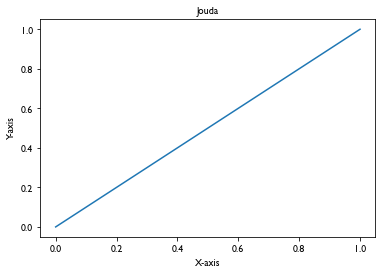

In [28]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
from matplotlib import rcParams
plt.rcParams['text.usetex'] = False
plt.rc('font', **font)

fs = 10
# Set global font size
rcParams.update({
    'font.size': fs,            # Base font size
    'axes.titlesize': fs,       # Title size
    'axes.labelsize': fs,       # X/Y label size
    'xtick.labelsize': fs,      # X-axis tick label
    'ytick.labelsize': fs,      # Y-axis tick label
    'legend.fontsize': fs,      # Legend text
})


# Your Gill Sans font file
gill_sans_path = "/gpfs/home/mep22dku/scratch/FONTS/gill-sans/GillSansMedium.otf"

# Register the font
gill_font = font_manager.FontProperties(fname=gill_sans_path)
font_manager.fontManager.addfont(gill_sans_path)

# Get internal name (important for mathtext settings)
gill_font_name = font_manager.FontProperties(fname=gill_sans_path).get_name()

# Set mathtext to use your font
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = gill_font_name
rcParams['mathtext.it'] = gill_font_name
rcParams['mathtext.bf'] = gill_font_name

# Specify the paths to the gill Sans font files
gill_sans = "/gpfs/home/mep22dku/scratch/FONTS/gill-sans/GillSansMedium.otf"
# Create FontProperties object
gill_font = font_manager.FontProperties(fname=gill_sans)



## paper fig 3

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


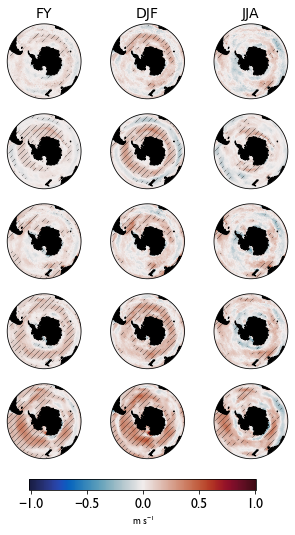

In [50]:
sdir = '/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/intProc/'
n = ['ERA5','UKESMEM','JRA','MERRA','NCEP-NCAR',]
seas = ['FY','DJF','JJA']#,'JJA','SON',]

fact = 0.25
fig = plt.figure(figsize=[21*fact, 48/6*4*fact])
tcm = cm.balance

botbound = -1.01; topbound = 1.01
#botbound = -0.1; topbound = 0.1
tint = 0.5
tcm = cm.balance
tcbr = True
ind = 1
for tn in n:
    for tseas in seas:
        
        ax1 = fig.add_subplot(5, 3, ind, projection=ccrs.Orthographic(0, -90))

        w = xr.open_dataset(f'{sdir}/TRENDS-{tn}-{tseas}-1980-2019.nc')
        test = w.lin_slope*10
        sig = w.lin_p
        lons = w.lon
        lats = w.lat
    
        if ind < 15:
            tcbr = False
        else:
            tcbr = True
        tit = ''
        if ind < 4 :
            tit = f'{tseas}'
        bc = plot_southern(fig, ax1, lons, lats, test, sig, botbound, 
                      topbound, np.arange(botbound,topbound,tint), fs = 14, 
                      tit =tit, cbarlab = 'm s$^{-1}$', tcmap = tcm, lm = True, cbr = tcbr,\
                          ccoords = [0.2, 0.07, .6, .02], hatch = True)
        ind = ind+1
        print(ind)


plt.tight_layout()


fig.savefig('./plts-gill/Fig-spattrend-1980-2019.jpg', dpi = 300, bbox_inches='tight')


### other figures taht were made at some point for reasons at this point lost to time

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


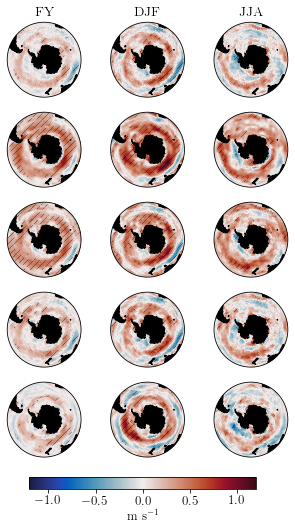

In [14]:
sdir = '/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/intProc/'
n = ['ERA5','NCEP-NCAR','MERRA','JRA','UKESM',]
seas = ['FY','DJF','JJA']#,'JJA','SON',]

fact = 0.25
fig = plt.figure(figsize=[21*fact, 48/6*4*fact])
tcm = cm.balance

botbound = -1.2
topbound = 1.2
tint = 0.5
tcm = cm.balance
tcbr = True
ind = 1
for tn in n:
    for tseas in seas:
        
        ax1 = fig.add_subplot(5, 3, ind, projection=ccrs.Orthographic(0, -90))

        w = xr.open_dataset(f'{sdir}/TRENDS-{tn}-{tseas}-1980-1999.nc')
        test = w.lin_slope*10
        sig = w.lin_p
        lons = w.lon
        lats = w.lat
    
        if ind < 15:
            tcbr = False
        else:
            tcbr = True
        tit = ''
        if ind < 4 :
            tit = f'{tseas}'
        bc = plot_southern(fig, ax1, lons, lats, test, sig, botbound, 
                      topbound, np.arange(botbound,topbound,tint), fs = 14, 
                      tit =tit, cbarlab = 'm/s', tcmap = tcm, lm = True, cbr = tcbr,\
                          ccoords = [0.2, 0.07, .6, .02], hatch = True)
        ind = ind+1
        print(ind)
        
#n = ['NCEP-NCAR','NCEP-DOE II','MERRA-2','JRA3Q','ERA5','UKESM',]
# wx = np.zeros([6])
# wx = np.array([0.82,  0.69, 0.566, 0.434, 0.3, 0.172])
# for i in range(0,6):
#     #wx[i] = 0.82 - 0.127*i
#     fig.text(-0.06,wx[i],f'{n[i]}')


plt.tight_layout()

if sn:
    fig.savefig('./plts/Fig-spattrend-1980-1999.jpg', dpi = 300, bbox_inches='tight')
tx = 0.1

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


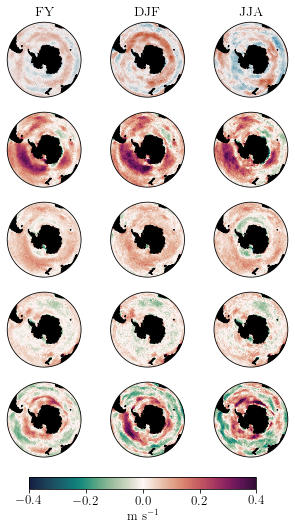

In [15]:
sdir = '/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/intProc/'
n = ['ERA5','NCEP-NCAR','MERRA','JRA','UKESM',]
seas = ['FY','DJF','JJA']#,'JJA','SON',]

fact = 0.25
fig = plt.figure(figsize=[21*fact, 48/6*4*fact])
tcm = cm.balance

botbound = -1.2
topbound = 1.2
tint = 0.5
tcm = cm.balance
tcbr = True
ind = 1
for tn in n:
    for tseas in seas:
        
        ax1 = fig.add_subplot(5, 3, ind, projection=ccrs.Orthographic(0, -90))

        if tn == 'ERA5':
            w = xr.open_dataset(f'{sdir}/TRENDS-{tn}-{tseas}-1980-2019.nc')
            test = w.lin_slope*10
            sig = w.lin_p
            lons = w.lon
            lats = w.lat
            botbound = -0.5
            topbound = 0.5
            tint = 0.5
            tcm = cm.balance
            
        else:
            w = xr.open_dataset(f'{sdir}/TRENDS-{tn}-{tseas}-1980-2019.nc')
            w2 = xr.open_dataset(f'{sdir}/TRENDS-ERA5-{tseas}-1980-2019.nc')
            test1 = w.lin_slope*10
            test2 = w2.lin_slope*10
            test = test1-test2
            sig = w.lin_p
            lons = w.lon
            lats = w.lat        
            botbound = -0.4
            topbound = 0.4
            tint = 0.05
            tcm = cm.curl
            
            
    
        if ind < 15:
            tcbr = False
        else:
            tcbr = True
        tit = ''
        if ind < 4 :
            tit = f'{tseas}'
        bc = plot_southern(fig, ax1, lons, lats, test, sig, botbound, 
                      topbound, np.arange(botbound,topbound,tint), fs = 14, 
                      tit =tit, cbarlab = 'm/s', tcmap = tcm, lm = True, cbr = tcbr,\
                          ccoords = [0.2, 0.07, .6, .02], hatch = False)
        ind = ind+1
        print(ind)
        
#n = ['NCEP-NCAR','NCEP-DOE II','MERRA-2','JRA3Q','ERA5','UKESM',]
# wx = np.zeros([6])
# wx = np.array([0.82,  0.69, 0.566, 0.434, 0.3, 0.172])
# for i in range(0,6):
#     #wx[i] = 0.82 - 0.127*i
#     fig.text(-0.06,wx[i],f'{n[i]}')

plt.tight_layout()
if sn:
    fig.savefig('./plts/Fig-spattrend-1980-2019-withdiff.jpg', dpi = 300, bbox_inches='tight')
tx = 0.1

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


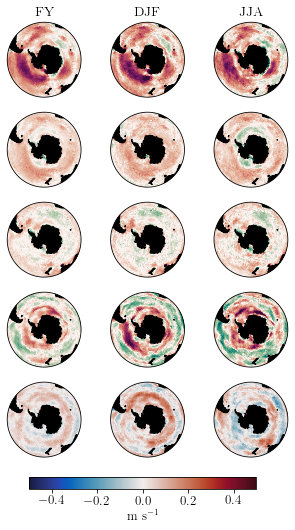

In [16]:

sdir = '/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/intProc/'
n = ['NCEP-NCAR','MERRA','JRA','UKESM','ERA5',]
seas = ['FY','DJF','JJA']#,'JJA','SON',]

fact = 0.25
fig = plt.figure(figsize=[21*fact, 48/6*4*fact])
tcm = cm.balance

botbound = -1.2
topbound = 1.2
tint = 0.5
tcm = cm.balance
tcbr = True
ind = 1
for tn in n:
    for tseas in seas:
        
        ax1 = fig.add_subplot(5, 3, ind, projection=ccrs.Orthographic(0, -90))

        if tn == 'ERA5':
            w = xr.open_dataset(f'{sdir}/TRENDS-{tn}-{tseas}-1980-2019.nc')
            test = w.lin_slope*10
            sig = w.lin_p
            lons = w.lon
            lats = w.lat
            botbound = -0.5
            topbound = 0.5
            tint = 0.5
            tcm = cm.balance
            
        else:
            w = xr.open_dataset(f'{sdir}/TRENDS-{tn}-{tseas}-1980-2019.nc')
            w2 = xr.open_dataset(f'{sdir}/TRENDS-ERA5-{tseas}-1980-2019.nc')
            test1 = w.lin_slope*10
            test2 = w2.lin_slope*10
            test = test1-test2
            sig = w.lin_p
            lons = w.lon
            lats = w.lat        
            botbound = -0.4
            topbound = 0.4
            tint = 0.05
            tcm = cm.curl
            
            
    
        if ind < 15:
            tcbr = False
        else:
            tcbr = True
        tit = ''
        if ind < 4 :
            tit = f'{tseas}'
        bc = plot_southern(fig, ax1, lons, lats, test, sig, botbound, 
                      topbound, np.arange(botbound,topbound,tint), fs = 14, 
                      tit =tit, cbarlab = 'm/s', tcmap = tcm, lm = True, cbr = tcbr,\
                          ccoords = [0.2, 0.07, .6, .02], hatch = False)
        ind = ind+1
        print(ind)
        
#n = ['NCEP-NCAR','NCEP-DOE II','MERRA-2','JRA3Q','ERA5','UKESM',]
# wx = np.zeros([6])
# wx = np.array([0.82,  0.69, 0.566, 0.434, 0.3, 0.172])
# for i in range(0,6):
#     #wx[i] = 0.82 - 0.127*i
#     fig.text(-0.06,wx[i],f'{n[i]}')

plt.tight_layout()
if sn:
    fig.savefig('./plts/Fig-spattrend-1980-2019-withdiff-ERAbar.jpg', dpi = 300, bbox_inches='tight')
tx = 0.1

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


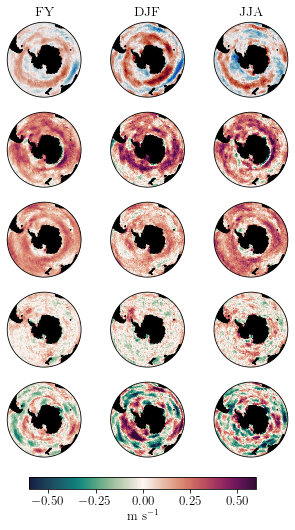

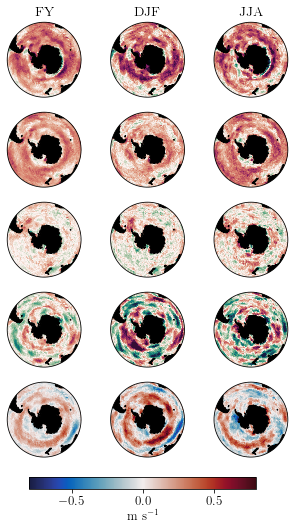

In [17]:

sdir = '/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/intProc/'
n = ['ERA5','NCEP-NCAR','MERRA','JRA','UKESM',]
seas = ['FY','DJF','JJA']#,'JJA','SON',]

fact = 0.25
fig = plt.figure(figsize=[21*fact, 48/6*4*fact])
tcm = cm.balance

botbound = -1.2
topbound = 1.2
tint = 0.5
tcm = cm.balance
tcbr = True
ind = 1
for tn in n:
    for tseas in seas:
        
        ax1 = fig.add_subplot(5, 3, ind, projection=ccrs.Orthographic(0, -90))

        if tn == 'ERA5':
            w = xr.open_dataset(f'{sdir}/TRENDS-{tn}-{tseas}-1980-1999.nc')
            test = w.lin_slope*10
            sig = w.lin_p
            lons = w.lon
            lats = w.lat
            botbound = -0.8
            topbound = 0.8
            tint = 0.5
            tcm = cm.balance
            
        else:
            w = xr.open_dataset(f'{sdir}/TRENDS-{tn}-{tseas}-1980-1999.nc')
            w2 = xr.open_dataset(f'{sdir}/TRENDS-ERA5-{tseas}-1980-1999.nc')
            test1 = w.lin_slope*10
            test2 = w2.lin_slope*10
            test = test1-test2
            sig = w.lin_p
            lons = w.lon
            lats = w.lat        
            botbound = -0.6
            topbound = 0.6
            tint = 0.05
            tcm = cm.curl
            
            
    
        if ind < 15:
            tcbr = False
        else:
            tcbr = True
        tit = ''
        if ind < 4 :
            tit = f'{tseas}'
        bc = plot_southern(fig, ax1, lons, lats, test, sig, botbound, 
                      topbound, np.arange(botbound,topbound,tint), fs = 14, 
                      tit =tit, cbarlab = 'm/s', tcmap = tcm, lm = True, cbr = tcbr,\
                          ccoords = [0.2, 0.07, .6, .02], hatch = False)
        ind = ind+1
        print(ind)
        
#n = ['NCEP-NCAR','NCEP-DOE II','MERRA-2','JRA3Q','ERA5','UKESM',]
# wx = np.zeros([6])
# wx = np.array([0.82,  0.69, 0.566, 0.434, 0.3, 0.172])
# for i in range(0,6):
#     #wx[i] = 0.82 - 0.127*i
#     fig.text(-0.06,wx[i],f'{n[i]}')

plt.tight_layout()
if sn:
    fig.savefig('./plts/Fig-spattrend-1980-1999-withdiff.jpg', dpi = 300, bbox_inches='tight')
tx = 0.1


sn = True
sdir = '/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/intProc/'
n = ['NCEP-NCAR','MERRA','JRA','UKESM','ERA5',]
seas = ['FY','DJF','JJA']#,'JJA','SON',]

fact = 0.25
fig = plt.figure(figsize=[21*fact, 48/6*4*fact])
tcm = cm.balance

botbound = -1.2
topbound = 1.2
tint = 0.5
tcm = cm.balance
tcbr = True
ind = 1
for tn in n:
    for tseas in seas:
        
        ax1 = fig.add_subplot(5, 3, ind, projection=ccrs.Orthographic(0, -90))

        if tn == 'ERA5':
            w = xr.open_dataset(f'{sdir}/TRENDS-{tn}-{tseas}-1980-1999.nc')
            test = w.lin_slope*10
            sig = w.lin_p
            lons = w.lon
            lats = w.lat
            botbound = -0.8
            topbound = 0.8
            tint = 0.5
            tcm = cm.balance
            
        else:
            w = xr.open_dataset(f'{sdir}/TRENDS-{tn}-{tseas}-1980-1999.nc')
            w2 = xr.open_dataset(f'{sdir}/TRENDS-ERA5-{tseas}-1980-1999.nc')
            test1 = w.lin_slope*10
            test2 = w2.lin_slope*10
            test = test1-test2
            sig = w.lin_p
            lons = w.lon
            lats = w.lat        
            botbound = -0.6
            topbound = 0.6
            tint = 0.05
            tcm = cm.curl
            
            
    
        if ind < 15:
            tcbr = False
        else:
            tcbr = True
        tit = ''
        if ind < 4 :
            tit = f'{tseas}'
        bc = plot_southern(fig, ax1, lons, lats, test, sig, botbound, 
                      topbound, np.arange(botbound,topbound,tint), fs = 14, 
                      tit =tit, cbarlab = 'm/s', tcmap = tcm, lm = True, cbr = tcbr,\
                          ccoords = [0.2, 0.07, .6, .02], hatch = False)
        ind = ind+1
        print(ind)
        
#n = ['NCEP-NCAR','NCEP-DOE II','MERRA-2','JRA3Q','ERA5','UKESM',]
# wx = np.zeros([6])
# wx = np.array([0.82,  0.69, 0.566, 0.434, 0.3, 0.172])
# for i in range(0,6):
#     #wx[i] = 0.82 - 0.127*i
#     fig.text(-0.06,wx[i],f'{n[i]}')

plt.tight_layout()
if sn:
    fig.savefig('./plts/Fig-spattrend-1980-1999-withdiff-ERAbar.jpg', dpi = 300, bbox_inches='tight')
tx = 0.1